$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

Saved to /home/matansudry/.pytorch-datasets/lfw-bush.zip.
Extracting /home/matansudry/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/matansudry/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

Found 530 images in dataset folder.


In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linaer1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

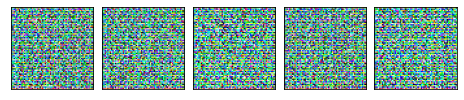

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [49]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 2, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 8e-06}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.001}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.89it/s]
Discriminator loss: 1.2891702840913017
Generator loss:     0.7489865330030333


--- EPOCH 2/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.38it/s]
Discriminator loss: 0.9456387212816274
Generator loss:     1.0047293384120148


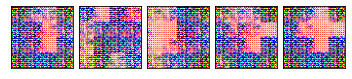

--- EPOCH 3/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.51it/s]
Discriminator loss: 0.7270841960918228
Generator loss:     1.3135221614027923


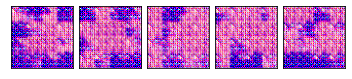

--- EPOCH 4/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.83it/s]
Discriminator loss: 0.9856532264992875
Generator loss:     1.2912407950410303


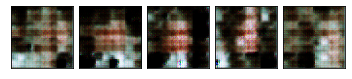

--- EPOCH 5/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.51it/s]
Discriminator loss: 1.4428778299745524
Generator loss:     0.7219688563976647


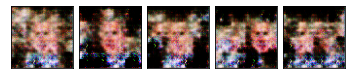

--- EPOCH 6/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.44it/s]
Discriminator loss: 1.368237751384951
Generator loss:     0.7629655800900369


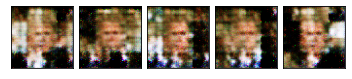

--- EPOCH 7/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.44it/s]
Discriminator loss: 1.3693897620686946
Generator loss:     0.7115556034277071


--- EPOCH 8/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.79it/s]
Discriminator loss: 1.3700549840927123
Generator loss:     0.7216634974164783


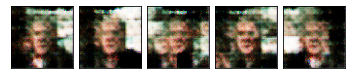

--- EPOCH 9/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.86it/s]
Discriminator loss: 1.3757423243432674
Generator loss:     0.738497398484428


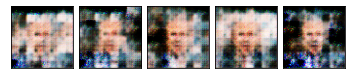

--- EPOCH 10/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.89it/s]
Discriminator loss: 1.3686825986178417
Generator loss:     0.7217928191400924


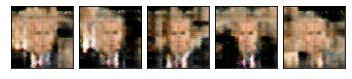

--- EPOCH 11/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.62it/s]
Discriminator loss: 1.3719296171980084
Generator loss:     0.7372408311322051
Saved checkpoint.


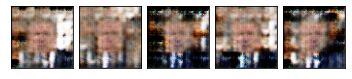

--- EPOCH 12/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.66it/s]
Discriminator loss: 1.3726330341033215
Generator loss:     0.731990968281368


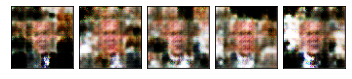

--- EPOCH 13/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.68it/s]
Discriminator loss: 1.3774748113920103
Generator loss:     0.7124047275984062


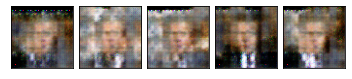

--- EPOCH 14/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.76it/s]
Discriminator loss: 1.3736505445444358
Generator loss:     0.7127973767946352


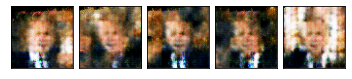

--- EPOCH 15/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.77it/s]
Discriminator loss: 1.3804015919847308
Generator loss:     0.7286161634157289


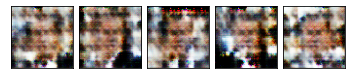

--- EPOCH 16/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.73it/s]
Discriminator loss: 1.3696107994835331
Generator loss:     0.7297347507386838


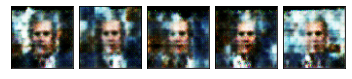

--- EPOCH 17/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.70it/s]
Discriminator loss: 1.3730530626368973
Generator loss:     0.7136174363910027


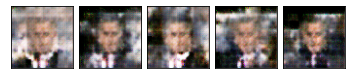

--- EPOCH 18/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.81it/s]
Discriminator loss: 1.3666980936842146
Generator loss:     0.721955819849698


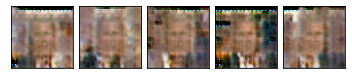

--- EPOCH 19/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.01it/s]
Discriminator loss: 1.357564280842835
Generator loss:     0.7327659197573392
Saved checkpoint.


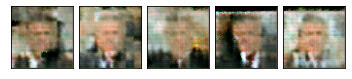

--- EPOCH 20/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.09it/s]
Discriminator loss: 1.3391879198686132
Generator loss:     0.7389745914711142
Saved checkpoint.


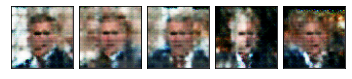

--- EPOCH 21/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.95it/s]
Discriminator loss: 1.3611034285347416
Generator loss:     0.7426151926787394


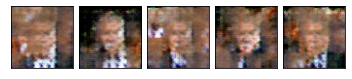

--- EPOCH 22/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.46it/s]
Discriminator loss: 1.3405730742328572
Generator loss:     0.7494577742972464
Saved checkpoint.


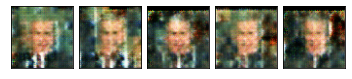

--- EPOCH 23/100 ---
100%|██████████| 265/265 [00:07<00:00, 33.52it/s]
Discriminator loss: 1.3236577553569147
Generator loss:     0.7603072229421364
Saved checkpoint.


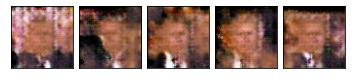

--- EPOCH 24/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.84it/s]
Discriminator loss: 1.3415079384479882
Generator loss:     0.7351290288961159


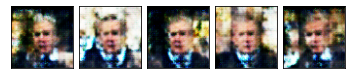

--- EPOCH 25/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.72it/s]
Discriminator loss: 1.3061433900077388
Generator loss:     0.7710750296430767
Saved checkpoint.


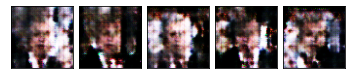

--- EPOCH 26/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.04it/s]
Discriminator loss: 1.318196194126921
Generator loss:     0.7567852684911692


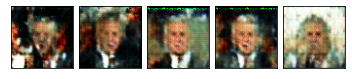

--- EPOCH 27/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.84it/s]
Discriminator loss: 1.31090157459367
Generator loss:     0.7743970472857638


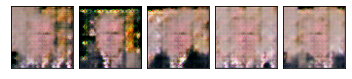

--- EPOCH 28/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.73it/s]
Discriminator loss: 1.2959908327966365
Generator loss:     0.7631805960862141
Saved checkpoint.


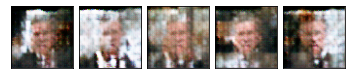

--- EPOCH 29/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.80it/s]
Discriminator loss: 1.292147227953065
Generator loss:     0.7597852660799926
Saved checkpoint.


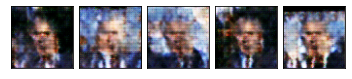

--- EPOCH 30/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.84it/s]
Discriminator loss: 1.3115618564047904
Generator loss:     0.7688526444839981


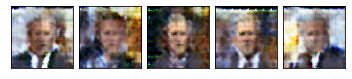

--- EPOCH 31/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.72it/s]
Discriminator loss: 1.3023327989398308
Generator loss:     0.7865241952662197
Saved checkpoint.


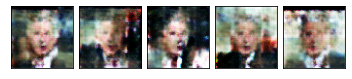

--- EPOCH 32/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.06it/s]
Discriminator loss: 1.2933960608716282
Generator loss:     0.7930823656747926
Saved checkpoint.


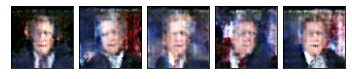

--- EPOCH 33/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.71it/s]
Discriminator loss: 1.278928158868034
Generator loss:     0.7714125609622812
Saved checkpoint.


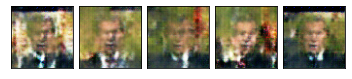

--- EPOCH 34/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.57it/s]
Discriminator loss: 1.2802864331119466
Generator loss:     0.8260402246466223
Saved checkpoint.


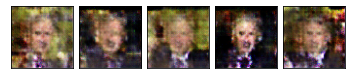

--- EPOCH 35/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.56it/s]
Discriminator loss: 1.2512942417612616
Generator loss:     0.8304934114780066
Saved checkpoint.


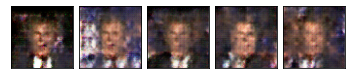

--- EPOCH 36/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.72it/s]
Discriminator loss: 1.2599087692656608
Generator loss:     0.8319702476825355


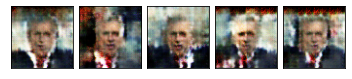

--- EPOCH 37/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.86it/s]
Discriminator loss: 1.2400503484707959
Generator loss:     0.8204932444500473
Saved checkpoint.


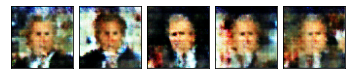

--- EPOCH 38/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.94it/s]
Discriminator loss: 1.2382880824916767
Generator loss:     0.8056420020337375


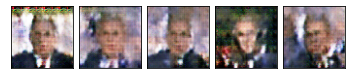

--- EPOCH 39/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.83it/s]
Discriminator loss: 1.2411869838552656
Generator loss:     0.8303061860912251
Saved checkpoint.


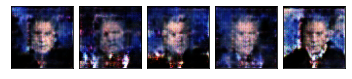

--- EPOCH 40/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.71it/s]
Discriminator loss: 1.1755723363948318
Generator loss:     0.8603722956945311
Saved checkpoint.


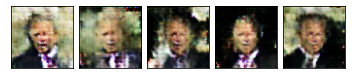

--- EPOCH 41/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.01it/s]
Discriminator loss: 1.2077148104613682
Generator loss:     0.8321492811418929


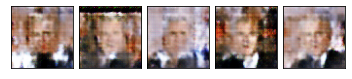

--- EPOCH 42/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.20it/s]
Discriminator loss: 1.1758635957286043
Generator loss:     0.9167720404436004
Saved checkpoint.


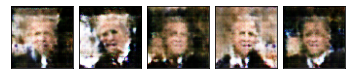

--- EPOCH 43/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.22it/s]
Discriminator loss: 1.1451111658564155
Generator loss:     0.8873177925370774
Saved checkpoint.


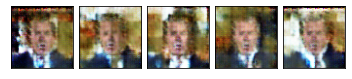

--- EPOCH 44/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.61it/s]
Discriminator loss: 1.1341734847932492
Generator loss:     0.882601070628976
Saved checkpoint.


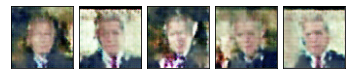

--- EPOCH 45/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.93it/s]
Discriminator loss: 1.1446823843245237
Generator loss:     0.8939252016679295


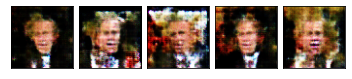

--- EPOCH 46/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.91it/s]
Discriminator loss: 1.1574697404537562
Generator loss:     0.941377425081325
Saved checkpoint.


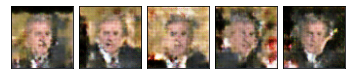

--- EPOCH 47/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.57it/s]
Discriminator loss: 1.127063521349205
Generator loss:     0.914203597577113
Saved checkpoint.


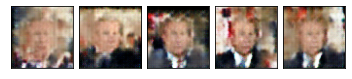

--- EPOCH 48/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.61it/s]
Discriminator loss: 1.117161398563745
Generator loss:     0.9216537257410445
Saved checkpoint.


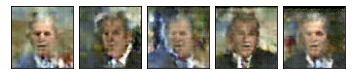

--- EPOCH 49/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.60it/s]
Discriminator loss: 1.0837716291535575
Generator loss:     0.9397927569893171
Saved checkpoint.


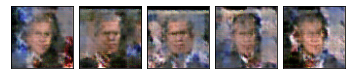

--- EPOCH 50/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.54it/s]
Discriminator loss: 1.0337643423170413
Generator loss:     0.969987763548797
Saved checkpoint.


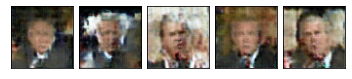

--- EPOCH 51/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.35it/s]
Discriminator loss: 1.0685838134783618
Generator loss:     1.0015080778103955


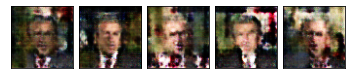

--- EPOCH 52/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.64it/s]
Discriminator loss: 1.018100266524081
Generator loss:     1.0426937274213106
Saved checkpoint.


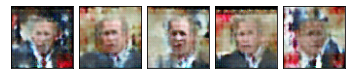

--- EPOCH 53/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.72it/s]
Discriminator loss: 1.0016668293835982
Generator loss:     1.0341072253461154


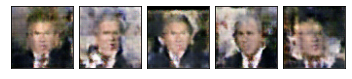

--- EPOCH 54/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.75it/s]
Discriminator loss: 1.0015382767848249
Generator loss:     1.0486129441351262


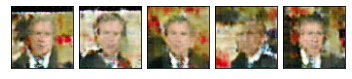

--- EPOCH 55/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.86it/s]
Discriminator loss: 0.958761770207927
Generator loss:     1.0762457687899751


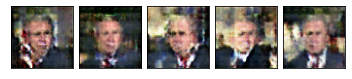

--- EPOCH 56/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.80it/s]
Discriminator loss: 0.9426145420884187
Generator loss:     1.0912213682003742


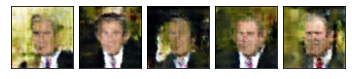

--- EPOCH 57/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.74it/s]
Discriminator loss: 0.9054418858492149
Generator loss:     1.0876390143385473


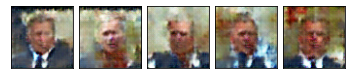

--- EPOCH 58/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.78it/s]
Discriminator loss: 0.955879208726703
Generator loss:     1.147347631319514


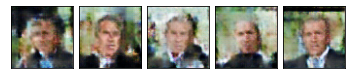

--- EPOCH 59/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.51it/s]
Discriminator loss: 0.8685486602333357
Generator loss:     1.170441512679154


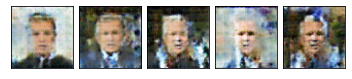

--- EPOCH 60/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.80it/s]
Discriminator loss: 0.8555073729101217
Generator loss:     1.2294216049167346


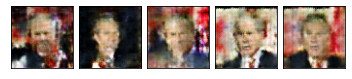

--- EPOCH 61/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.57it/s]
Discriminator loss: 0.8395737479317863
Generator loss:     1.1884688809232893


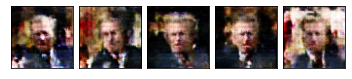

--- EPOCH 62/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.79it/s]
Discriminator loss: 0.8542110738889226
Generator loss:     1.2375374528596985


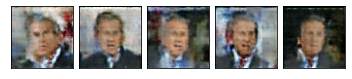

--- EPOCH 63/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.40it/s]
Discriminator loss: 0.7920004911580176
Generator loss:     1.2591787160567518


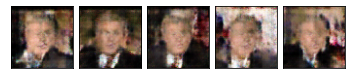

--- EPOCH 64/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.92it/s]
Discriminator loss: 0.7983194487274817
Generator loss:     1.2381134917151253


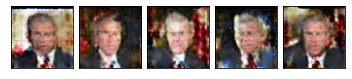

--- EPOCH 65/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.49it/s]
Discriminator loss: 0.7906819576362394
Generator loss:     1.3023951944315209


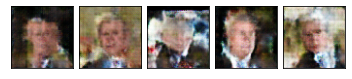

--- EPOCH 66/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.52it/s]
Discriminator loss: 0.7228655071191068
Generator loss:     1.325744559404985


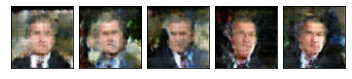

--- EPOCH 67/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.55it/s]
Discriminator loss: 0.7340620866361655
Generator loss:     1.3916952705608223


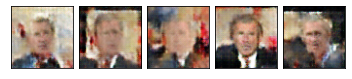

--- EPOCH 68/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.45it/s]
Discriminator loss: 0.7096080776655449
Generator loss:     1.363664577817017


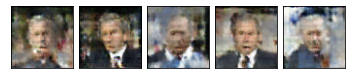

--- EPOCH 69/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.65it/s]
Discriminator loss: 0.6797863417076615
Generator loss:     1.4956752918801217


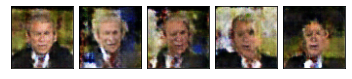

--- EPOCH 70/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.72it/s]
Discriminator loss: 0.6649239519997587
Generator loss:     1.4911522125298122


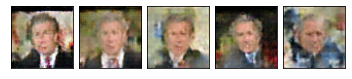

--- EPOCH 71/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.06it/s]
Discriminator loss: 0.6531861817921107
Generator loss:     1.5162749410800214


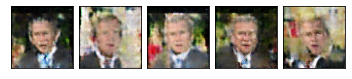

--- EPOCH 72/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.77it/s]
Discriminator loss: 0.5995458847790395
Generator loss:     1.5433411013405278


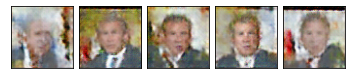

--- EPOCH 73/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.75it/s]
Discriminator loss: 0.6219950215012398
Generator loss:     1.65456320362271


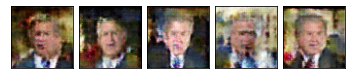

--- EPOCH 74/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.69it/s]
Discriminator loss: 0.5848517070682544
Generator loss:     1.7130757581512883


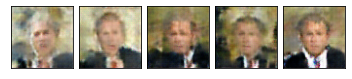

--- EPOCH 75/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.18it/s]
Discriminator loss: 0.5831572437202031
Generator loss:     1.7157867602582249


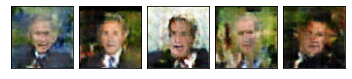

--- EPOCH 76/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.57it/s]
Discriminator loss: 0.5549347905055532
Generator loss:     1.7250609134728054


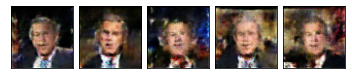

--- EPOCH 77/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.61it/s]
Discriminator loss: 0.5570816691472845
Generator loss:     1.7412643233560166


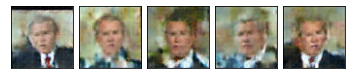

--- EPOCH 78/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.66it/s]
Discriminator loss: 0.5428732366213259
Generator loss:     1.7831067706054111


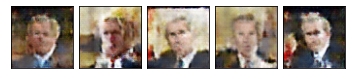

--- EPOCH 79/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.77it/s]
Discriminator loss: 0.5220256027326269
Generator loss:     1.845721348276678


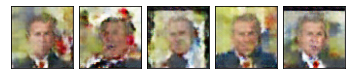

--- EPOCH 80/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.68it/s]
Discriminator loss: 0.4809694501588929
Generator loss:     1.86539895860654


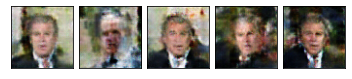

--- EPOCH 81/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.74it/s]
Discriminator loss: 0.4902280241532146
Generator loss:     1.8646827136570552


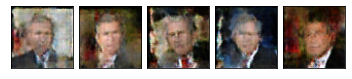

--- EPOCH 82/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.79it/s]
Discriminator loss: 0.4685570334769645
Generator loss:     2.0054583482022554


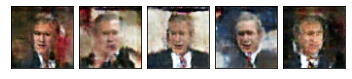

--- EPOCH 83/100 ---
100%|██████████| 265/265 [00:07<00:00, 33.88it/s]
Discriminator loss: 0.4363939381995291
Generator loss:     2.0882375395522925


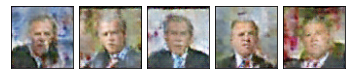

--- EPOCH 84/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.88it/s]
Discriminator loss: 0.43808410687828964
Generator loss:     2.1176439346007583


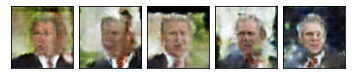

--- EPOCH 85/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.79it/s]
Discriminator loss: 0.3924859347208491
Generator loss:     1.9808656647520246


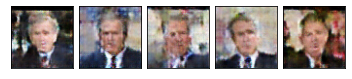

--- EPOCH 86/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.64it/s]
Discriminator loss: 0.4094249466398977
Generator loss:     2.1959455603698514


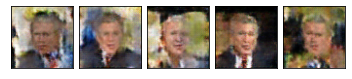

--- EPOCH 87/100 ---
100%|██████████| 265/265 [00:07<00:00, 37.52it/s]
Discriminator loss: 0.3471651689342733
Generator loss:     2.180591002725205


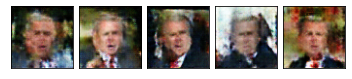

--- EPOCH 88/100 ---
100%|██████████| 265/265 [00:07<00:00, 36.79it/s]
Discriminator loss: 0.3363770233010346
Generator loss:     2.206827044936846


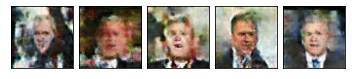

--- EPOCH 89/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.57it/s]
Discriminator loss: 0.36801550895819124
Generator loss:     2.3366615378631734


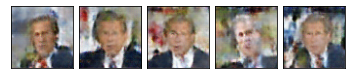

--- EPOCH 90/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.82it/s]
Discriminator loss: 0.32183954355851657
Generator loss:     2.380431284994449


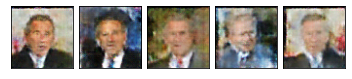

--- EPOCH 91/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.45it/s]
Discriminator loss: 0.3089106502116851
Generator loss:     2.4789933386838663


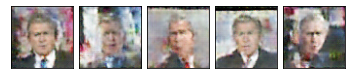

--- EPOCH 92/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.31it/s]
Discriminator loss: 0.33979224836770094
Generator loss:     2.5574071157653377


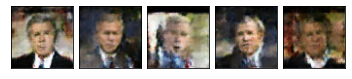

--- EPOCH 93/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.81it/s]
Discriminator loss: 0.29951643751899026
Generator loss:     2.581182504599949


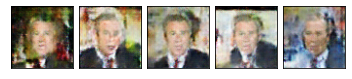

--- EPOCH 94/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.67it/s]
Discriminator loss: 0.2497611978846901
Generator loss:     2.625140709134768


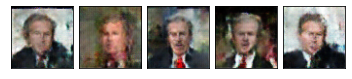

--- EPOCH 95/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.61it/s]
Discriminator loss: 0.32310519803245114
Generator loss:     2.590688566666729


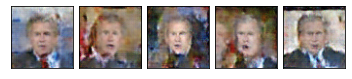

--- EPOCH 96/100 ---
100%|██████████| 265/265 [00:07<00:00, 35.55it/s]
Discriminator loss: 0.2763406102668564
Generator loss:     2.663925331718517


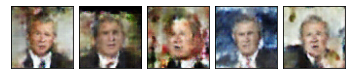

--- EPOCH 97/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.57it/s]
Discriminator loss: 0.2810783326906978
Generator loss:     2.7265797699397467


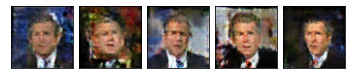

--- EPOCH 98/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.82it/s]
Discriminator loss: 0.27472642105564754
Generator loss:     2.8237372744758176


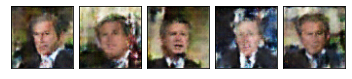

--- EPOCH 99/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.23it/s]
Discriminator loss: 0.2680577501092317
Generator loss:     2.797143395441883


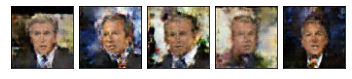

--- EPOCH 100/100 ---
100%|██████████| 265/265 [00:07<00:00, 34.83it/s]
Discriminator loss: 0.2557492926787093
Generator loss:     2.826042826895444


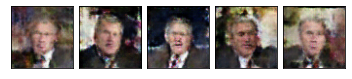

In [50]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


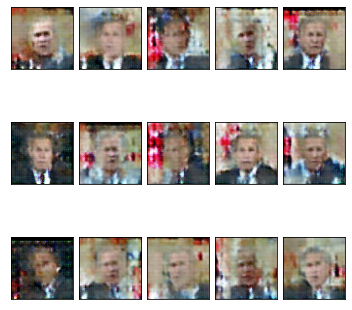

In [51]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [52]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [53]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


The loss in GAN are splitted to 2, discriminator loss and generator loss.
The training process has 2 stages, imporving generated images and imporving discriminator to classify between real and fake images.
When we are imporving the generated stage we want to tune to CNN parameters so the grad should be part of it.
When we are imporving the classification stage we want to keep the grad and only imporving the discriminator so we are turning the grad. 



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [54]:
display_answer(hw3.answers.part3_q2)


**Your answer:**
1.  The target of the network is to generate new image that will be close the real images so the discriminator will know which are the real and which are the fake.
    in case the discriminator will think all the picture are real the loss of the generator will be 0 but we dont know if we are doing good job are just the discriminator doing bad job.
    we think that generator only will not produce good images and most consider the discriminator loss.
2. if the generator loss decreases and the discriminator loss stay the same it means the discriminator have classified more real images as fake and more fake as real, by that the loss keep the same for the discriminator and decrease for the generator.



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [55]:
display_answer(hw3.answers.part3_q3)


**Your answer:**

VAE as praducing the picture more passport like with smooth background and we think the main reason for that is the algorithem is more "mean" focus using L2 norm
GAN has different kinds of background and the faces are not good like the VAE because we think GAN are not focusing on the "mean" as the VAE.

